# Diffraction shift correction with py4DSTEM

The code in this notebook determines the shifts of the diffraction pattern in a 4D-STEM dataset associated with the scanning of the electron beam, then corrects those shifts, outputting a new 4D data hypercube in which the shifts have been removed.

The general procedure is as follows:
1. Get vacuum probe
2. Get shifts
    * Get raw shifts
    * Fit shifts
3. Correct the shifts

In [47]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.morphology import binary_dilation as binary_dilation

In [48]:
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
dc = py4DSTEM.readwrite.read_data(fp)

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5 is a py4DSTEM HDF5 file.  Reading...


## 1. Get the vacuum probe

The aim here is to create a convolution kernel in the shape of the unscattered electron beam, which can then be used to identify the Bragg disks in each diffraction pattern of the datacube.  We procede as follows:

* Get average vacuum probe
    * Select an ROI over (nearly) vacuum
    * Find shifts of DPs within ROI relative to one reference DP
    * Register and average all DPs in ROI
* Create vacuum probe kernel
    * Mask probe outside of central disk
    * Get probe CoM and size
    * Normalize probe to integrate to 1
    * Subtract normalized 2D gaussian to get kernel integrating to 0
    * Center kernel in Fourier space (i.e. at corners of array)

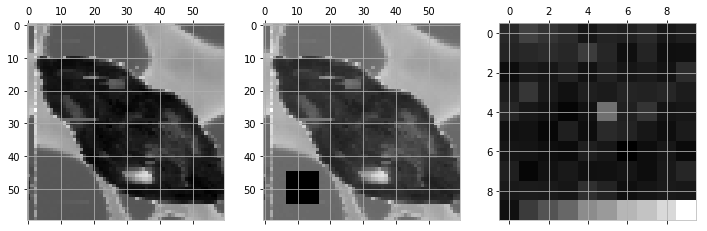

In [51]:
# ROI

xmin,xmax=45,55
ymin,ymax=7,17

im_ROI_sel = np.average(dc.data4D,axis=(2,3))
im_ROI_sel[xmin:xmax,ymin:ymax] = 0
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(np.average(dc.data4D,axis=(2,3)),cmap='gray')
ax2.matshow(im_ROI_sel,cmap='gray')
ax3.matshow(np.average(dc.data4D,axis=(2,3))[xmin:xmax,ymin:ymax,],cmap='gray')
plt.show()

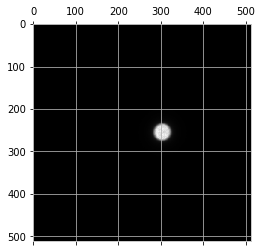

In [35]:
# Average DP, unshifted

DP_ave_unshifted = np.average(dc.data4D[xmin:xmax,ymin:ymax],axis=(0,1))

fig,ax=plt.subplots()
ax.matshow(DP_ave_unshifted,cmap='gray')
plt.show()

In [143]:
def make_Fourier_coords1D(N, pixelSize):
    """
    Generates 1D Fourier coordinates.
    """
    if N%2 == 0:
        q = np.roll( np.arange(-N/2,N/2)/(N*pixelSize), int(N/2))
    else:
        q = np.roll( np.arange((1-N)/2,(N+1)/2)/(N*pixelSize), int((1-N)/2))
    return q
    
def make_Fourier_coords2D(Ny, Nx, pixelSize):
    """
    Generates 2D Fourier coordinates.
    """
    qx = make_Fourier_coords1D(Nx,pixelSize)
    qy = make_Fourier_coords1D(Ny,pixelSize)
    qy,qx = np.meshgrid(qy,qx)
    qy,qx = qy.T,qx.T
    return qy,qx

In [218]:
def get_shift(im1,im2):
    cc = np.fft.ifft2(np.fft.fft2(im1)*np.conj(np.fft.fft2(im2)))
    xshift,yshift = np.unravel_index(np.argmax(cc),dc.data4D.shape[2:4])
    return xshift,yshift

def get_shifted_im(im,yshift,xshift):
    ny,nx = np.shape(im)
    qy,qx = make_Fourier_coords2D(ny,nx,1)
    nx,ny = float(nx),float(ny)
    
    w = np.exp(-(2j*np.pi)*( (yshift*qy) + (xshift*qx) ))
    shifted_im = np.abs(np.fft.ifft2((np.fft.fft2(im))*w))
    return shifted_im

In [219]:
# Get average shifted diffraction pattern

ref_DP = dc.data4D[xmin,ymin,:,:]

for n in range(1,(xmax-xmin)*(ymax-ymin)):
    i = xmin + n%(xmax-xmin)
    j = ymin + int(n/(xmax-xmin))
    curr_DP = dc.data4D[i,j,:,:]
    
    xshift,yshift = get_shift(ref_DP, curr_DP)
    curr_DP_shifted = get_shifted_im(curr_DP,xshift,yshift)
    ref_DP = ref_DP*(n-1)/n + curr_DP_shifted/n

In [220]:
def get_CoM(im):
    nx,ny=np.shape(im)
    rx,ry = np.meshgrid(np.arange(nx),np.arange(ny))
    tot_intens = np.sum(im)
    xCoM = np.sum(rx*im)/tot_intens
    yCoM = np.sum(ry*im)/tot_intens
    return xCoM,yCoM

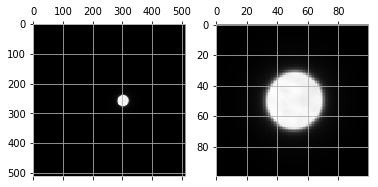

In [221]:
# Get (initial) center of mass
# Show shifted, averaged DP

xCoM_init,yCoM_init = get_CoM(ref_DP)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(ref_DP,cmap='gray')
ax2.matshow(ref_DP[int(yCoM_init)-50:int(yCoM_init)+50,int(xCoM_init)-50:int(xCoM_init)+50])
plt.show()

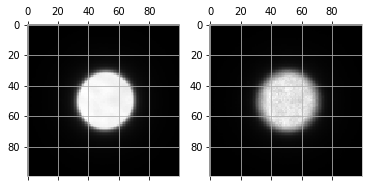

In [222]:
# Compare shifted to unshifted ave DPs

xCoM_unshifted,yCoM_unshifted = get_CoM(DP_ave_unshifted)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(ref_DP[int(yCoM_init)-50:int(yCoM_init)+50,int(xCoM_init)-50:int(xCoM_init)+50])
ax2.matshow(DP_ave_unshifted[int(yCoM_unshifted)-50:int(yCoM_unshifted)+50,int(xCoM_unshifted)-50:int(xCoM_unshifted)+50])
plt.show()

In [41]:
# Mask probe outside of central disk

mask_thresh = 0.2
mask_expansion = 12

rx,ry = np.meshgrid(dc.data4D.shape[1],dc.data4D.shape[0])
mask = ref_DP > np.max(ref_DP)*mask_thresh
mask = binary_dilation(mask,iterations=mask_expansion)

#maskDist = 0.5 + 0.5*erf(maskShift + (bwdist(~maskRound) - bwdist(bwmorph(maskRound,'dilate',1))) / (0.5*maskWidth));

probe_template = ref_DP*mask

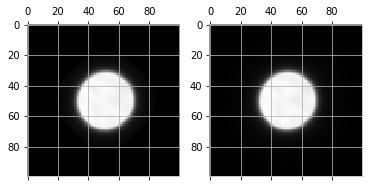

Mask alters CoM by 0.31014000886091364 pixels.


In [42]:
# Get CoM
# Compare to CoM without mask

xCoM,yCoM = get_CoM(probe_template)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe_template[int(yCoM)-50:int(yCoM)+50,int(xCoM)-50:int(xCoM)+50])
ax2.matshow(ref_DP[int(yCoM_init)-50:int(yCoM_init)+50,int(xCoM_init)-50:int(xCoM_init)+50])
plt.show()

print("Mask alters CoM by {} pixels.".format(np.sqrt((yCoM-yCoM_init)**2+(xCoM-xCoM_init)**2)))

In [43]:
# Get probe size

r2 = (rx-xCoM)**2 + (ry-yCoM)**2
rstd = np.sum(r2*probe_template*mask) / np.sum(probe_template)

In [44]:
# Normalize probe to one
# Subtract off gaussian, to yield a kernel which integrates to zero
sigma_probe_scale = 5

probe_template_norm = probe_template/np.sum(probe_template)
subtr_gaussian = probe_template_norm - np.exp(-r2 / (2*rstd*sigma_probe_scale**2))
subtr_gaussian = subtr_gaussian/np.sum(subtr_gaussian)
probe_kernel = probe_template_norm - subtr_gaussian

print("Probe kernel sums to {}.".format(np.sum(probe_kernel)))

Probe kernel sums to -6.106226635438361e-16.


In [45]:
# Shift probe kernel to center, then to corners
probe_kernel = get_shifted_im(probe_kernel,(xCoM-dc.data4D.shape[2]/2),(yCoM-dc.data4D.shape[3]/2))
#probe_kernel = np.fft.fftshift(probe_kernel)

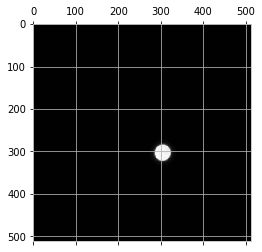

In [46]:
fig,ax=plt.subplots()
ax.matshow(probe_kernel,cmap='gray')
plt.show()

In [21]:
xCoM

300.7663129805576

In [22]:
yCoM

259.24117011726486